In [20]:
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer, GraphLIME
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith
from torch_geometric.utils import k_hop_subgraph
from graphxai.utils import Explanation, EnclosingSubgraph
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [37]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(
    model_layers = 3,
    num_subgraphs = 8,
    subgraph_size = 5,
    prob_connection = 0.3,
    add_sensitive_feature = False
)

# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

100%|██████████| 11/11 [00:00<00:00, 330.22it/s]

Graph Data: Data(x=[40, 10], edge_index=[2, 118], y=[40], shape=[40])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x0000019A46D11D90>], [<graphxai.utils.explanation.Explanation object at 0x0000019A46F8CB20>], [<graphxai.utils.explanation.Explanation object at 0x0000019A2A27EE80>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CD90>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CDC0>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CC40>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CE20>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CAF0>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CFD0>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CDF0>], [<graphxai.utils.explanation.Explanation object at 0x0000019A4492CBB0>], [<graphxai.utils.explanation.Explanation object at 0x0000019A449386A0>], [<graphxai.utils.explanation.Expl

In [38]:
print(data.keys)

['y', 'shape', 'edge_index', 'x']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn.functional as F
from graphxai.gnn_models.node_classification.testing import (
    GCN_3layer_basic,GIN_3layer_basic, GAT_3layer_basic, GSAGE_3layer
)
from graphxai.gnn_models.node_classification import GCN,train, test

# Asumsi data ShapeGGen tersedia di dataset.graph
data = dataset.get_graph(use_fixed_split=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(torch.unique(data.y)) 

# Pilih model yang ingin digunakan
model_choice = 'GCN'  # Ganti menjadi 'GIN', 'GAT', atau 'GSAGE' sesuai model yang ingin digunakan

# Inisialisasi model berdasarkan pilihan
if model_choice == 'GCN':
    # can use GCN_3layer_basic or GCN
    model = GCN_3layer_basic(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
elif model_choice == 'GIN':
    model = GIN_3layer_basic(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
elif model_choice == 'GAT':
    model = GAT_3layer_basic(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
elif model_choice == 'GSAGE':
    model = GSAGE_3layer(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Hitung bobot berdasarkan distribusi label
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.cpu()), y=data.y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Gunakan saat inisialisasi loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Training loop
for epoch in range(300):
    loss = train(model, optimizer, criterion, data)

# Evaluasi model
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes=num_classes, get_auc=True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))


Test F1 score: 0.9091
Test AUROC: 1.0000


In [73]:
print(torch.bincount(data.y))


tensor([18, 22])


In [74]:
class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        # Pastikan model ada di device yang benar (kalau CPU/GPU beda)
        self.model = self.model.to(x.device)

        # Panggil GraphLIME asli, tapi log sebelum dan sesudah
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")

        return result


# Inisialisasi explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)
lime_explainer = SafeGraphLIME(model)

In [75]:
# === Perbaikan explainer agar menggunakan node_idx yang sama ===

def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    """
    Konversi explanation dari subgraph ke full graph
    """
    # Buat node importance untuk full graph
    full_node_imp = torch.zeros(data.num_nodes)
    
    # Perlakuan khusus untuk GraphLIME yang menghasilkan feature_imp bukan node_imp
    if hasattr(exp, 'feature_imp') and exp.feature_imp is not None and exp.node_imp is None:
        # Untuk GraphLIME, kita hanya mengatur importance pada node target
        if hasattr(exp, 'node_idx'):
            target_node = exp.node_idx
            if isinstance(target_node, torch.Tensor):
                target_node = target_node.item()
            # Gunakan mean dari feature importance sebagai node importance
            mean_imp = exp.feature_imp.mean().item()
            full_node_imp[target_node] = mean_imp
    else:
        # Untuk explainer lain yang menghasilkan node_imp
        if exp.node_imp is not None:
            for i, imp in enumerate(exp.node_imp):
                if i < len(subset):  # Pastikan index valid
                    full_node_imp[subset[i]] = imp
    
    # Buat explanation untuk full graph
    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx  # Gunakan node_idx asli
    )
    
    # Set enc_subgraph setelah membuat objek
    full_exp.enc_subgraph = EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
    
    # Buat node_reference yang benar
    full_exp.node_reference = {}
    for sub_idx, full_idx in enumerate(subset):
        full_exp.node_reference[full_idx.item()] = sub_idx
    
    return full_exp

# === Persiapan data ===
# Ambil satu node untuk dijelaskan
node_idx = 8  # Pastikan node ini valid dan ada di train mask
x, edge_index = data.x, data.edge_index
# === Ambil Subgraph k-hop (khusus Grad dan GNN) ===
num_hops = 2
subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, 
    num_nodes=data.num_nodes, flow='source_to_target'
)
sub_x = data.x[subset]

# PERBAIKAN: Node_idx dalam subgraph untuk node_idx=10
sub_node_idx = mapping.item()  # Mapping ke posisi node 10 dalam subgraph

# === Jalankan explainer dengan node_idx yang benar ===
# PERBAIKAN: Pastikan semua explainer fokus pada node yang sama (sub_node_idx)
grad_explanation = grad_explainer.get_explanation_node(
    sub_node_idx, sub_x, sub_edge_index  # Gunakan sub_node_idx yang benar
)
gnn_explanation = gnn_explainer.get_explanation_node(
    sub_node_idx, sub_x, sub_edge_index  # Gunakan sub_node_idx yang benar
)

# PGM dan GraphLIME juga gunakan node_idx yang sama (node 10)
pgm_explanation = pgm_explainer.get_explanation_node(
    node_idx, data.x, data.edge_index  # node_idx = 10
)
lime_explanation = lime_explainer.get_explanation_node(
    node_idx, data.x, data.edge_index  # node_idx = 10
)

# === Konversi ke format seragam ===
grad_full_exp = convert_to_full_explanation(
    grad_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
gnn_full_exp = convert_to_full_explanation(
    gnn_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
pgm_full_exp = convert_to_full_explanation(
    pgm_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
lime_full_exp = convert_to_full_explanation(
    lime_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 8
[SafeGraphLIME] Selesai explain node 8



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [76]:
# Ground truth explanation dari ShapeGGen
ground_truth = dataset.explanations[node_idx][0]  # Extract the Explanation object from the list

# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_explanation)
gea_gnn = graph_exp_acc(ground_truth, gnn_explanation)
gea_pgm = graph_exp_acc(ground_truth, pgm_explanation)
# khusus LIME (karena lebih ke feature importance bukan node jadi di konversi ke node)
# Dapatkan feature importance dari GraphLIME
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)

# Konversi feature importance GraphLIME ke node importance
node_importance = lime_explanation.feature_imp.mean().item()
lime_node_importance = torch.zeros(data.num_nodes)  # Untuk full graph
lime_node_importance[node_idx] = node_importance

# Buat node_reference lengkap untuk full graph
node_reference = {i: i for i in range(data.num_nodes)}

# Buat edge_mask manual (untuk mendukung versi lama torch_geometric)
edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
for edge_id, (src, dst) in enumerate(data.edge_index.T):
    if src in subset and dst in subset:
        edge_mask[edge_id] = True

class ExplanationCompat(Explanation):
    def __init__(self, enc_subgraph=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.enc_subgraph = enc_subgraph

lime_exp = ExplanationCompat(
    node_imp=lime_node_importance,
    node_idx=node_idx,
    enc_subgraph=EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
)

lime_exp.node_reference = node_reference  # Ini kunci utama!
gea_lime = graph_exp_acc(ground_truth, lime_exp)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")
print(f"GraphLIME: {gea_lime:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
gef_grad = graph_exp_faith(grad_explanation, dataset, model)
gef_gnn = graph_exp_faith(gnn_explanation, dataset, model)
gef_pgm = graph_exp_faith(pgm_explanation, dataset, model)
gef_lime = graph_exp_faith(lime_exp, dataset, model)
print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")
print(f"GraphLIME: {gef_lime:.4f}")

[SafeGraphLIME] Memulai explain node 8
[SafeGraphLIME] Selesai explain node 8
Graph Explanation Accuracy:
Grad: 0.0000
GNNExplainer: 0.3000
PGMExplainer: 0.0000
GraphLIME: 0.0000

Graph Explanation Faithfulness:
Grad: 1.0000
GNNExplainer: 1.0000
PGMExplainer: 1.0000
GraphLIME: 1.0000


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


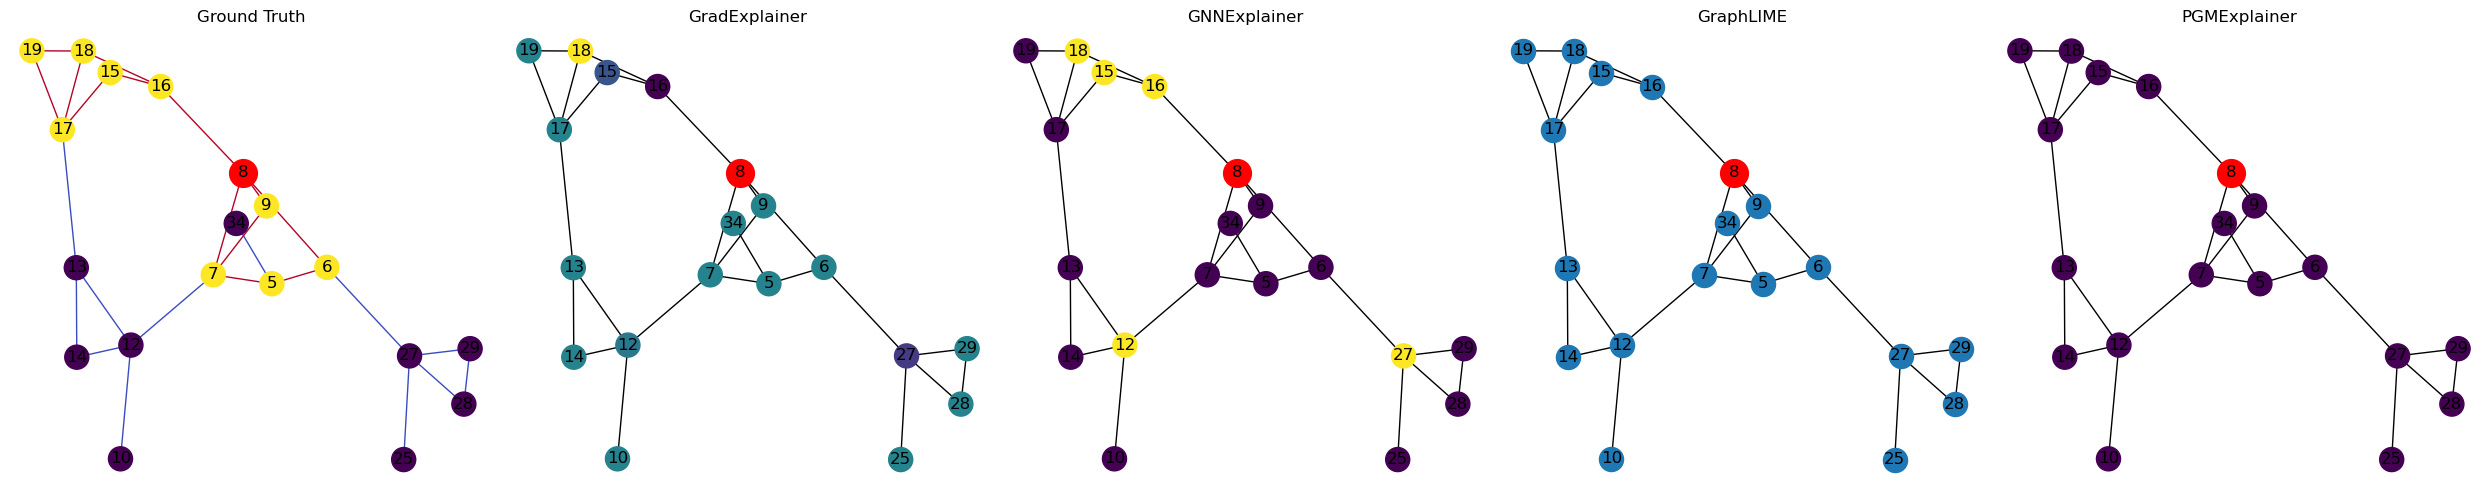

In [77]:
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Helper untuk ambil subgraf dari enc_subgraph
def get_data_from_explanation(exp, full_data):
    subset = exp.enc_subgraph.nodes
    edge_index = exp.enc_subgraph.edge_index
    return Data(
        x=full_data.x[subset],
        edge_index=edge_index,
        y=full_data.y[subset]
    )

# Pastikan node_idx dalam bentuk int
if isinstance(node_idx, torch.Tensor):
    node_idx = node_idx.item()

# Siapkan subplot 1 baris 5 kolom
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1. Ground Truth dari ShapeGGen
dataset.explanations[node_idx][0].visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[0],
    show_node_labels=True
)
ax[0].set_title("Ground Truth")

# 2. GradExplainer - Use grad_full_exp
if isinstance(grad_full_exp.node_idx, torch.Tensor):
 grad_full_exp.node_idx = grad_full_exp.node_idx.item()

# When visualizing a full explanation, pass the full graph data
grad_full_exp.visualize_node(
    num_hops=2, # num_hops should likely still be 2 to match the explanation's locality
    graph_data=data, # Pass the full graph data
    ax=ax[1],
    show_node_labels=True
)
ax[1].set_title("GradExplainer")

# 3. GNNExplainer - Use gnn_full_exp
if isinstance(gnn_full_exp.node_idx, torch.Tensor):
 gnn_full_exp.node_idx = gnn_full_exp.node_idx.item()

# When visualizing a full explanation, pass the full graph data
gnn_full_exp.visualize_node(
    num_hops=2, # num_hops should likely still be 2
    graph_data=data, # Pass the full graph data
    ax=ax[2],
    show_node_labels=True
)
ax[2].set_title("GNNExplainer")

# 4. GraphLIME (gunakan graf penuh)
if isinstance(lime_explanation.node_idx, torch.Tensor):
    lime_explanation.node_idx = lime_explanation.node_idx.item()
lime_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[3],
    show_node_labels=True
)
ax[3].set_title("GraphLIME")

# 5. PGMExplainer (juga gunakan graf penuh)
if isinstance(pgm_explanation.node_idx, torch.Tensor):
    pgm_explanation.node_idx = pgm_explanation.node_idx.item()
pgm_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[4],
    show_node_labels=True
)
ax[4].set_title("PGMExplainer")

# Tata letak rapi
plt.tight_layout()
plt.show()

In [55]:
from graphxai.utils import Explanation, EnclosingSubgraph

class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        self.model = self.model.to(x.device)
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")
        return result

lime_explainer = SafeGraphLIME(model)

# Update function to handle GraphLIME conversion
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for name, explainer in zip(names, explainers):
        if name == 'GraphLIME':
            lime_exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            # Konversi feature importance ke node importance
            node_imp = torch.zeros(data.num_nodes)
            node_imp[node_idx] = lime_exp.feature_imp.mean().item()

            # Buat enclosing subgraph info
            subset, sub_edge_index, mapping, _ = k_hop_subgraph(
                node_idx, 2, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
            )
            edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
            for i, (u, v) in enumerate(data.edge_index.t()):
                if u in subset and v in subset:
                    edge_mask[i] = True

            enc_subgraph = EnclosingSubgraph(
                nodes=subset,
                edge_index=sub_edge_index,
                inv=mapping,
                edge_mask=edge_mask,
                directed=False
            )

            lime_exp_final = Explanation(
                node_imp=node_imp,
                node_idx=node_idx
            )
            lime_exp_final.enc_subgraph = enc_subgraph
            lime_exp_final.node_reference = {0: node_idx}

            explanations.append(lime_exp_final)
        else:
            exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            explanations.append(exp)

    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# List explainer
explainers = [grad_explainer, gnn_explainer, pgm_explainer, lime_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer', 'GraphLIME']

compare_explanations(node_idx, data, explainers, names)


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 8
[SafeGraphLIME] Selesai explain node 8

GradExplainer top 5 important nodes:
Node 3: -8.7842
Node 2: -7.8413
Node 4: -6.3746
Node 1: -5.1704
Node 0: -4.3626

GNNExplainer top 5 important nodes:
Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000

PGMExplainer top 5 important nodes:
Node 7: 1.0000
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000

GraphLIME top 5 important nodes:
Node 8: 0.0150
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
